In [1]:
import cv2
import json
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines)
from src.utils.const import ref_snooker_playfield
from src.utils.playfield_finder import PlayfieldFinder
from src.utils.points import Point
from src.utils.lines import Line
import numpy as np
from src.utils.plotting import display_img, plot_on_image
import src.config
from src.utils.metrics import iou, _reorder_pts
from src.utils.intersections import compute_intersections
from src.utils.annotations import transform_annotation
from pathlib import Path
import pandas as pd
from src.utils.annotations import PolygonAnnotation
import matplotlib.pyplot as plt

In [2]:
picname = 'pic_07_36_02'
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png  pic_08_08_01.png pic_06_16_02.png
cropped_pic = crop_center(pic)

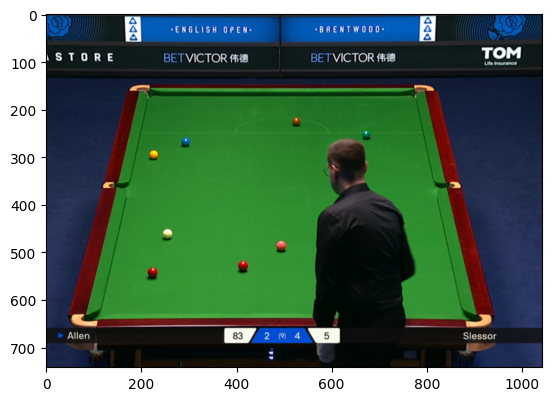

In [3]:
display_img(pic)

#### find playfield

In [4]:
finder = PlayfieldFinder(pic)

##### find internal bottom cushion

In [5]:
internal_bottom_cushion = finder.find_bottom_internal_cushion()
internal_bottom_cushion

y = 0.0 * x + 629.0

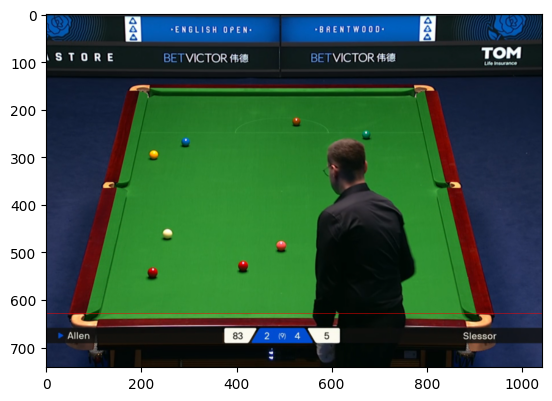

In [6]:
display_img(plot_on_image(pic, lines=[internal_bottom_cushion], line_thickness=1))

In [7]:
# ground_truth_dir = Path('playfield_gt')
# wrong_pics = pd.read_excel('/home/polymorvic/Desktop/zdjecia_do_poprawy.ods')['col2'].tolist()
# all_ground_truth = []
# for json_file in sorted(ground_truth_dir.glob('*.json')):
#     with open(json_file, 'r') as f:
#         data = json.load(f)
        
#         # Jeśli plik nie jest poprawione.json, filtruj obiekty z wrong_pics
#         if json_file.name != 'poprawione.json':
#             # Filtruj obiekty, których nazwa obrazu jest w wrong_pics
#             filtered_data = []
#             for item in data:
#                 # Wyciągnij nazwę obrazu z file_upload lub data['image']
#                 image_name = None
#                 if 'file_upload' in item:
#                     # Usuń prefix z file_upload (np. "1ad6ab54-pic_01_15_02.png" -> "pic_01_15_02.png")
#                     file_upload = item['file_upload']
#                     # Znajdź część po ostatnim "-" jeśli istnieje, w przeciwnym razie użyj całej nazwy
#                     if '-' in file_upload:
#                         image_name = file_upload.split('-', 1)[1]
#                     else:
#                         image_name = file_upload
#                 elif 'data' in item and 'image' in item['data']:
#                     # Wyciągnij nazwę z pełnej ścieżki
#                     image_path = item['data']['image']
#                     image_name = Path(image_path).name
                
#                 # Dodaj tylko jeśli nazwa obrazu nie jest w wrong_pics
#                 if image_name and image_name not in wrong_pics:
#                     filtered_data.append(item)
            
#             all_ground_truth.extend(filtered_data)
#         else:
#             # Dla poprawione.json dodaj wszystkie obiekty
#             all_ground_truth.extend(data) 


In [8]:
# all_ground_truth

# cleaned_annotations = []
# for ann in all_ground_truth:
#     try:
#         result = ann['annotations'][0]['result'][0]
#         image_path = ann['data']['image']
#         image_name = image_path.replace('\\', '/').split('/')[-1].split('-', 1)[-1]
        
#         annotation_data = {
#             'points': result['value']['points'],
#             'image' :{
#                 'name': image_name,
#                 'width': result['original_width'],
#                 'height': result['original_height']
#             }
#         }
#         cleaned_annotations.append(annotation_data)
#     except (KeyError, IndexError, TypeError):
#         continue


In [9]:
# with open('playfield_gt/all.json', 'w') as f:
#     json.dump(cleaned_annotations, f, indent=4)




In [10]:
polygon_annp = PolygonAnnotation(root_dir='playfield_gt')
polygon_annp.read(Path('playfield_gt/all.json'))

In [11]:
root = Path('pics')
results = []
ious = []
pic_names = []
for file in sorted(root.glob('*.png')):
    # print(file.stem)
    pic = read_image_as_numpyimage(file, 'rgb')
    finder = PlayfieldFinder(pic)
    internal_bottom_cushion = None
    y_ref = None
    data = polygon_annp.filter_by_image(file.name)
    if data is None:
        print(file.name)
        
    else:
        points_gt = np.asarray(transform_annotation(pic, data.points))

        y_coords = points_gt[:, 1]
        y_ref = int(np.median(np.sort(y_coords)[-2:]))

    try:
        internal_bottom_cushion = finder.find_bottom_internal_cushion()
        pts = internal_bottom_cushion.limit_to_img(pic)
        pic_copy = cv2.cvtColor(pic, cv2.COLOR_RGB2BGR)
        cv2.line(pic_copy, *pts, (255, 0, 0), 1)
        cv2.imwrite(f'bottom_line_tests/test_{file.stem}.png', pic_copy)
        
    except Exception as e:
        print(f'Error processing {file}: {e}')

    finally:
        results.append(
            {'pic_name': file.name, 
            'internal_bottom_cushion': internal_bottom_cushion, 
            'intercept_ref': y_ref,
            'intercept_pred': internal_bottom_cushion.intercept if internal_bottom_cushion is not None else None,
            }) 


In [12]:
df = pd.DataFrame(results)
df['diff']= df['intercept_ref'] - df['intercept_pred']
df['abs_diff']= np.abs(df['intercept_ref'] - df['intercept_pred'])

In [13]:
df.to_excel('bottom_cushion_results.xlsx', index=False)

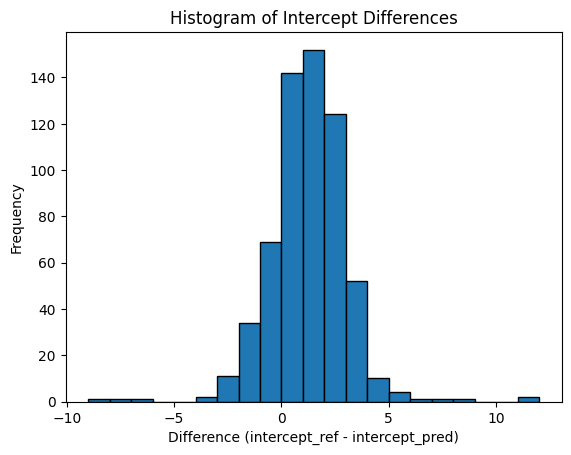

In [14]:
# Calculate bins based on binwidth=1
diff_clean = df['diff'].dropna()

min_val = diff_clean.min()
max_val = diff_clean.max()
bins = np.arange(min_val, max_val + 1, 1)  # binwidth = 1
plt.hist(diff_clean, bins=bins, edgecolor='black')
plt.xlabel('Difference (intercept_ref - intercept_pred)')
plt.ylabel('Frequency')
plt.title('Histogram of Intercept Differences')
plt.show()


In [15]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.7549342105263158),
 np.float64(1.8135882848194353))

In [14]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.7549342105263158),
 np.float64(1.8135882848194353))

In [14]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.7495881383855024),
 np.float64(1.8102829661544182))

In [14]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(1.0527182866556837),
 np.float64(1.7754806976239825))

In [11]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.8369028006589786),
 np.float64(2.1321263257027057))

In [ ]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.8109452736318408),
 np.float64(2.027406802014305))

In [15]:
wrong_pics = pd.read_excel('/home/polymorvic/Desktop/zdjecia_do_poprawy.ods')[['col2']]

In [16]:
df

,pic_name,internal_bottom_cushion,intercept_ref,intercept_pred,diff,abs_diff
0,pic_01_02_01.png,y = 0.0 * x + 774.0,777,774.0,3.0,3.0
1,pic_01_03_01.png,y = 0.0 * x + 704.0,704,704.0,0.0,0.0
2,pic_01_04_01.png,y = 0.0 * x + 719.0,719,719.0,0.0,0.0
3,pic_01_05_01.png,y = 0.0 * x + 733.0,739,733.0,6.0,6.0
4,pic_01_06_01.png,y = 0.0 * x + 683.0,685,683.0,2.0,2.0
...,...,...,...,...,...,...
603,pic_09_51_02.png,y = 0.0 * x + 573.0,574,573.0,1.0,1.0
604,pic_09_52_01.png,y = 0.0 * x + 597.0,598,597.0,1.0,1.0
605,pic_09_53_01.png,y = 0.0 * x + 575.0,577,575.0,2.0,2.0
606,pic_09_55_01.png,y = 0.0 * x + 585.0,584,585.0,-1.0,1.0


<Axes: >

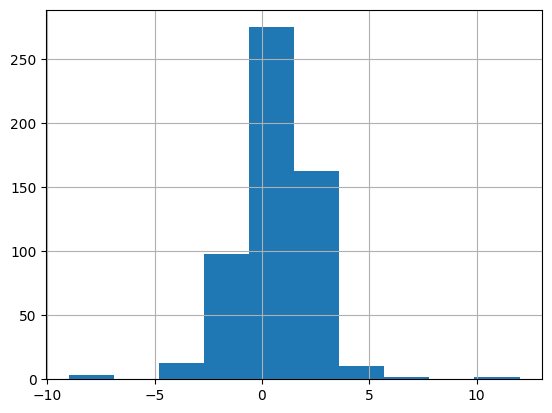

In [17]:
df[~df['pic_name'].isin(wrong_pics['col2'])].sort_values(by='abs_diff', ascending=False)['diff'].hist()

<Axes: >

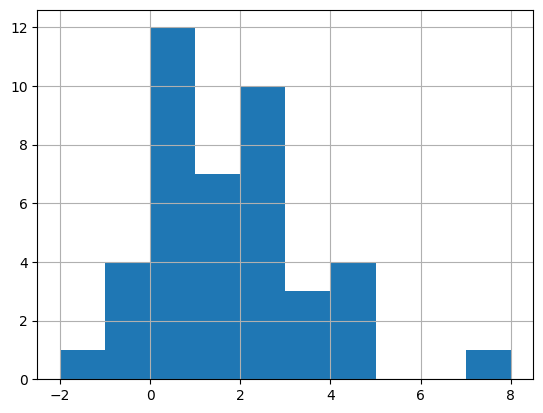

In [18]:
df[df['pic_name'].isin(wrong_pics['col2'])].sort_values(by='abs_diff', ascending=False)['diff'].hist()

In [ ]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(1.1376451077943615),
 np.float64(1.9088774318750903))

In [ ]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.23383084577114427),
 np.float64(2.724330467519728))

In [ ]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.13266998341625208),
 np.float64(3.747731628733281))

In [ ]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.13266998341625208),
 np.float64(3.747731628733281))

In [ ]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.23294509151414308),
 np.float64(2.6600086739169417))

In [ ]:
df['diff'].median()

np.float64(0.0)

In [ ]:
df['diff'].std()

np.float64(3.412700984392582)

In [ ]:
df['diff'].mean()

np.float64(-0.15307820299500832)

In [ ]:
picname = 'pic_07_13_01'

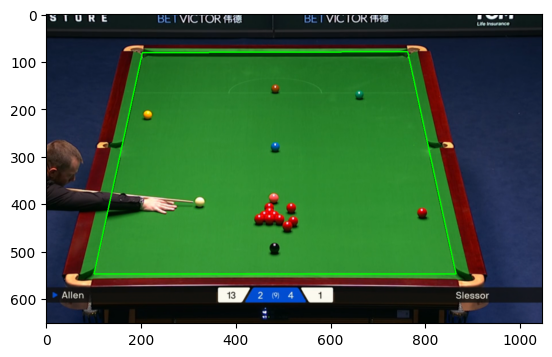

In [ ]:
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb')
data = polygon_annp.filter_by_image('pic_07_13_01.png')
points_gt = np.asarray(transform_annotation(pic, data.points))
display_img(plot_on_image(pic, polygons=[transform_annotation(pic, data.points)]))

pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb')

In [ ]:
transform_annotation(pic, data.points)

[Point(91.79939472546474, 647.2434608733248),
 Point(1034.6517509727623, 648.6984435797665),
 Point(909.9885970600949, 74.13343060959794),
 Point(221.12202766969295, 74.04507133592737)]

In [16]:
with open('playfield_gt/runda_5.json', 'r') as f:
    data = json.load(f)

In [20]:
with open('playfield_gt/ssss.json', 'w') as f:
    json.dump(data, f, indent=4)